# Generate weight to relate the density of events

The longitude and latitude of event provide information for their interconnection. We use the averge of the k-nearest neighbor distance to infer the reverse density. The intuition is the $$ P(\text{drunk driver} \| \text{accident}, \text{loc})= \frac{P(\text{drunk driver}, \text{accident}, \text{loc})}{P(\text{accident}|\text{loc})}$$

In [1]:
%reset 
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import sqlite3
from sklearn.neighbors import kneighbors_graph

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# read the accident file
print("Load accident data set")
acc_trn_df = pd.read_csv("./train/accident_train.csv")
acc_trn_df.fillna(0, inplace=True)
n_acc= len(acc_trn_df.index)

Load accident data set


In [3]:
acc_trn_latlon_df = acc_trn_df.loc[:,['LATITUDE','LONGITUD']]
acc_trn_latlon_df['LATITUDE'] = acc_trn_latlon_df['LATITUDE'].map(lambda x: x if(x <= 90 and x>= -90) 
                                                                  else np.random.randint(low= 30, high= 50, size=1))
acc_trn_latlon_df['LONGITUD'] = acc_trn_latlon_df['LONGITUD'].map(lambda x: x if(x <= 180 and x>= -180) 
                                                                  else np.random.randint(low=-130, high=-80, size=1))
acc_trn_df.loc[:,['LATITUDE','LONGITUD']] = acc_trn_latlon_df 

from sklearn.cluster import DBSCAN
print("Use DBSCAN - Density-Based Spatial Clustering of Applications with Noise to cluser")
dbscan = DBSCAN(eps=1, min_samples = 280, algorithm='kd_tree')

In [4]:
rho = 0.2
n_acc= len(acc_trn_df.index)
np.random.seed(12130) 
randIndex2 = np.random.choice(acc_trn_latlon_df.index.tolist(), np.ceil(n_acc*rho).astype(np.int64))

subsample_trn = acc_trn_latlon_df.loc[randIndex2,:]
dbscan.fit(X=subsample_trn.values)
labels = dbscan.labels_
dbscan_values = dbscan.components_      

sns.distplot(labels[np.random.choice(len(labels), 1000)], kde=False, rug=True) 

unique_labels = np.unique(labels)
import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=-1, vmax=unique_labels[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

randIndex2 = np.random.choice(acc_trn_latlon_df.dropna(axis=0).index.tolist(), 50000)
temp2 = acc_trn_latlon_df.loc[randIndex2,:]

from mpl_toolkits.basemap import Basemap
fig = plt.figure()
fig.set_size_inches(30,30)
m = Basemap(llcrnrlon=-130, llcrnrlat=np.min(temp2['LATITUDE']), 
            urcrnrlon=np.max(temp2['LONGITUD']), urcrnrlat=50, 
            #llcrnrlon=np.min(temp2['LONGITUD'])-20, llcrnrlat=np.min(temp2['LATITUDE'])-10, \
            #urcrnrlon=np.max(temp2['LONGITUD'])+20, urcrnrlat=np.max(temp2['LATITUDE'])+10,\
            projection='lcc', resolution='i', area_thresh=1, lat_1=-40, lat_2=42,lon_0=-85)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
for c in np.unique(labels):
    lons = acc_trn_latlon_df.loc[randIndex2[labels==c],'LONGITUD'].values
    lats = acc_trn_latlon_df.loc[randIndex2[labels==c],'LATITUDE'].values
    x, y = m(lons, lats)
    colorVal = scalarMap.to_rgba(c)
    m.scatter(x, y, s=20, marker='o', color=colorVal, label=str(c))

#ax = plt.gca()
#handles, labels = ax.get_legend_handles_labels()  
plt.legend()
plt.show()

predict labels for other samples

n_batch = 10000
label_temp = np.zeros((n_acc,),dtype=np.int64)
#np.ceil(n_acc/n_batch)

for i in np.arange(np.ceil(n_acc/n_batch).astype(np.int64), dtype=np.int64):
    if i != np.ceil(n_acc/n_batch)-1:
        index_set = acc_trn_df.index[np.arange(start=i*n_batch, stop=(i+1)*n_batch)]
        temp_val = acc_trn_df.loc[index_set,['LATITUDE','LONGITUD']].values
        label_temp[i*n_batch:(i+1)*n_batch] = dbscan.fit_predict(temp_val)
    else:
        index_set = acc_trn_df.index[np.arange(start=i*n_batch, stop=n_acc)]
        temp_val = acc_trn_df.loc[index_set,['LATITUDE','LONGITUD']].values
        label_temp[i*n_batch:n_acc] = dbscan.fit_predict(temp_val)

array_temp = np.column_stack((acc_trn_df['ID'].astype(np.int64).tolist(),label_temp))   
acc_trn_lat_lon_label_df = pd.DataFrame(data=array_temp, columns=["ID","LAT_LON_CLUSTER"])

## Compute the knn graph from kd-tree

In [5]:
k = 20 #find 280 nearest neigbhors

In [6]:
Knn_Graph = kneighbors_graph(X=acc_trn_latlon_df, n_neighbors=k, mode='distance', metric='minkowski', p=2)

In [7]:
weight_sum = Knn_Graph.sum(axis=0) / k

In [8]:
weight_sum.sum()

17300.805882357781

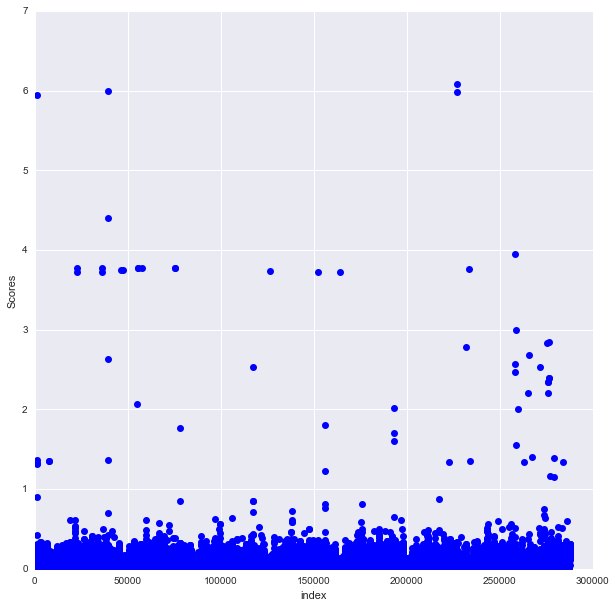

In [9]:
fig = plt.figure() 
fig.set_size_inches(10,10) 
width = 0.001
p1 = plt.plot(randIndex2, weight_sum[:,randIndex2].T, 'ob')
plt.ylabel('Scores')
plt.xlabel('index')
plt.show()   

In [10]:
normal_weight = weight_sum / weight_sum.sum() * n_acc

In [12]:
temp = np.column_stack((acc_trn_df['ID'].astype(np.int64).tolist(), normal_weight.T))   

In [13]:
weight_df = pd.DataFrame(data = temp,   columns=["ID", "WEIGHT"])
weight_df

,ID,WEIGHT
0,0,0.824355
1,1,0.798398
2,2,0.814209
3,3,1.354746
4,4,1.205015
5,5,1.072101
6,6,0.670482
7,7,1.244788
8,8,1.149064
9,9,1.696344


In [14]:
weight_df.to_csv("./train/weight_train.csv", index=False)

In [16]:
temp = pd.read_csv("./train/weight_train.csv")
temp.shape

(287586, 2)